In [1]:
# #Set up google colab working environment
# %cd ~/../content
# %rm -rf Colombian-peso-counterfeit-detection
# !git clone https://github.com/zrosen3/Colombian-peso-counterfeit-detection.git 
# %cd /content/Colombian-peso-counterfeit-detection/Code  

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
import common_functions as cf

# CNN

In [3]:
def Reshape5D(time_steps: int = 1, rows: int = 480, cols: int = 640, channels: int = 1):
    def Helper(x, y):
        # Reshape the element to have dimensions (time_steps, rows, cols, channels)
        return tf.reshape(x, [-1, time_steps, rows, cols, channels]), y
    return Helper

In [4]:
def MakeModel(class_names: list) -> tf.keras.Sequential:
    """
    Simple straight forward CNN model. this is just for simplicity and testing
    atm. I will make it more modular later once I know what we are doing

    Args:
        class_names: list of the classification names
        conv_layers: list of how many filters each convolutional layer should use
        layers: list with the sizes of each hidden layer
    
    Returns:
        `tf.keras.Sequential` - a constructed tf model
    """
    tf.keras.backend.clear_session()
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Rescaling(1./255))
    model.add(tf.keras.layers.ConvLSTM2D(16, 3, kernel_regularizer='l2', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(rate=0.4))
    model.add(tf.keras.layers.Dense(len(class_names))) # output

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    return model
    

## Load Data

In [5]:
train_ds, test_ds, validation_ds, class_names = cf.LoadData(color="grayscale", path="../Data/Augmented/", batch_size=8)

Found 24958 files belonging to 13 classes.
Found 8320 files belonging to 13 classes.
Found 8320 files belonging to 13 classes.


In [6]:
model = MakeModel(class_names)
history = model.fit(
    train_ds.map(Reshape5D()), 
    validation_data=validation_ds.map(Reshape5D()),
    epochs=10
)

Epoch 1/10
3120/3120 [==============================] - 481s 152ms/step - loss: 1.5367 - accuracy: 0.4753 - val_loss: 1.2634 - val_accuracy: 0.5862
Epoch 2/10
3120/3120 [==============================] - 473s 152ms/step - loss: 0.9318 - accuracy: 0.7182 - val_loss: 0.7348 - val_accuracy: 0.7954
Epoch 3/10
3120/3120 [==============================] - 459s 147ms/step - loss: 0.6562 - accuracy: 0.8165 - val_loss: 0.6187 - val_accuracy: 0.8209
Epoch 4/10
3120/3120 [==============================] - 458s 147ms/step - loss: 0.4832 - accuracy: 0.8733 - val_loss: 0.5157 - val_accuracy: 0.8569
Epoch 5/10
3120/3120 [==============================] - 458s 147ms/step - loss: 0.3834 - accuracy: 0.9053 - val_loss: 0.3923 - val_accuracy: 0.8999
Epoch 6/10
3120/3120 [==============================] - 458s 147ms/step - loss: 0.3036 - accuracy: 0.9274 - val_loss: 0.3079 - val_accuracy: 0.9308
Epoch 7/10
3120/3120 [==============================] - 458s 147ms/step - loss: 0.2469 - accuracy: 0.9455 - val_

# Evaluate

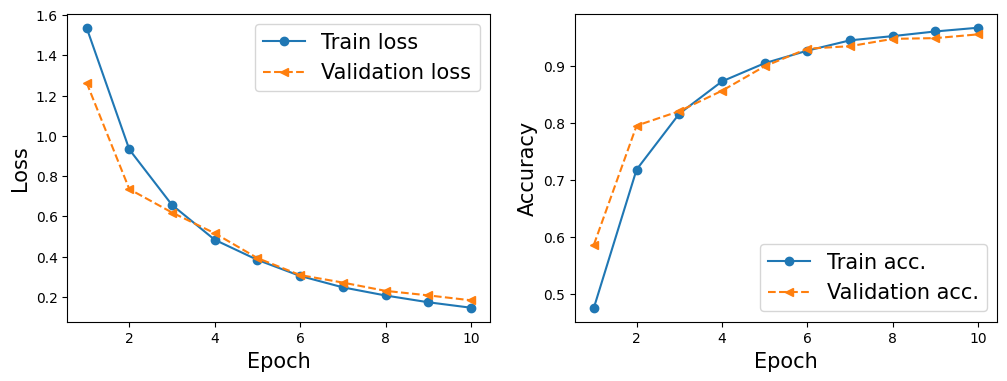

1040/1040 - 42s - loss: 0.1851 - accuracy: 0.9532 - 42s/epoch - 40ms/step
Test loss: 0.1850731372833252 | Test accuracy: 0.9532451629638672


(0.9676656723022461, 0.9560096263885498, 0.9532451629638672)

In [7]:
cf.EvaluateModel(model, test_ds.map(Reshape5D()), history)

In [8]:
cf.precision_recall_metrics(model, test_ds, class_names)

ValueError: in user code:

    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 2111, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential' (type Sequential).
    
    Input 0 of layer "conv_lstm2d" is incompatible with the layer: expected shape=(None, None, 480, 640, 1), found shape=(None, 480, 640, 1, 1)
    
    Call arguments received by layer 'sequential' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 480, 640, 1), dtype=float32)
      • training=False
      • mask=None


# Results

1. (0.07564708590507507, 0.07692307978868484, 0.07692307978868484)

